In [ ]:

!git clone https://github.com/ayushbits/pe-ocr-sanskrit

fatal: destination path 'pe-ocr-sanskrit' already exists and is not an empty directory.


In [ ]:
image_file='/content/pe-ocr-sanskrit/OCR-Images-Annotation/BHSv1S1/page-095.txt'
RECT_SIZE=(480,2)

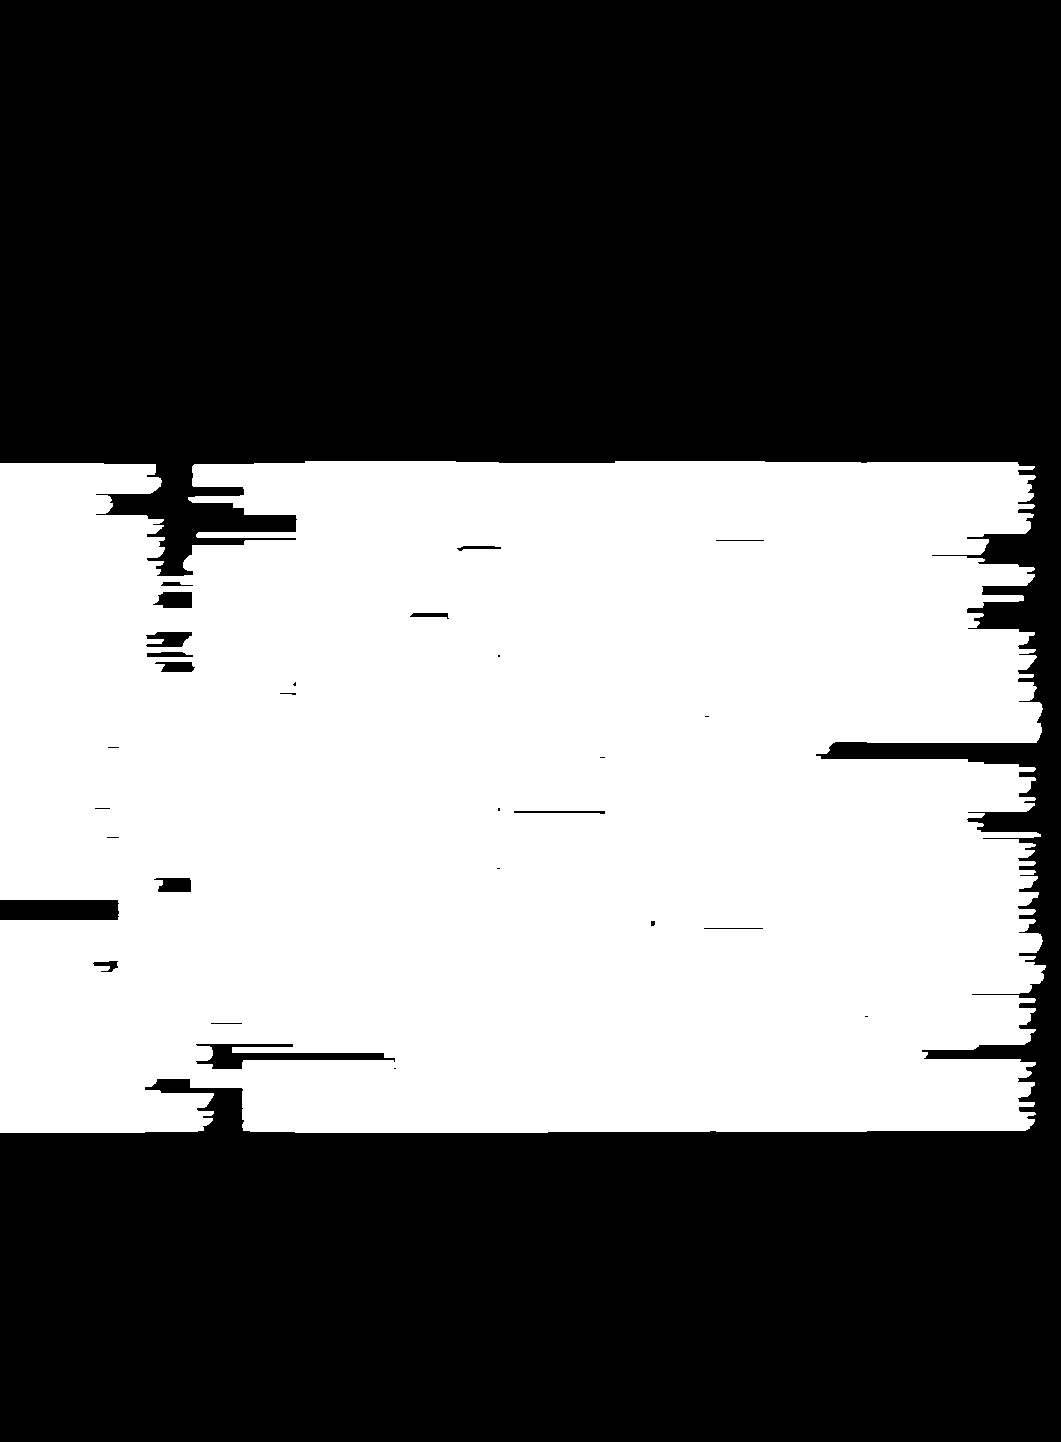

In [ ]:
# Masking
import cv2
from google.colab.patches import cv2_imshow

img = cv2.imread('/content/pe-ocr-sanskrit/OCR-Images-Annotation/BHSv1S1/page-095.jpeg')
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, thresh2 = cv2.threshold(img_gray, 150, 255, cv2.THRESH_BINARY_INV)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (150,2))
mask = cv2.morphologyEx(thresh2, cv2.MORPH_DILATE, kernel)
cv2_imshow(mask)


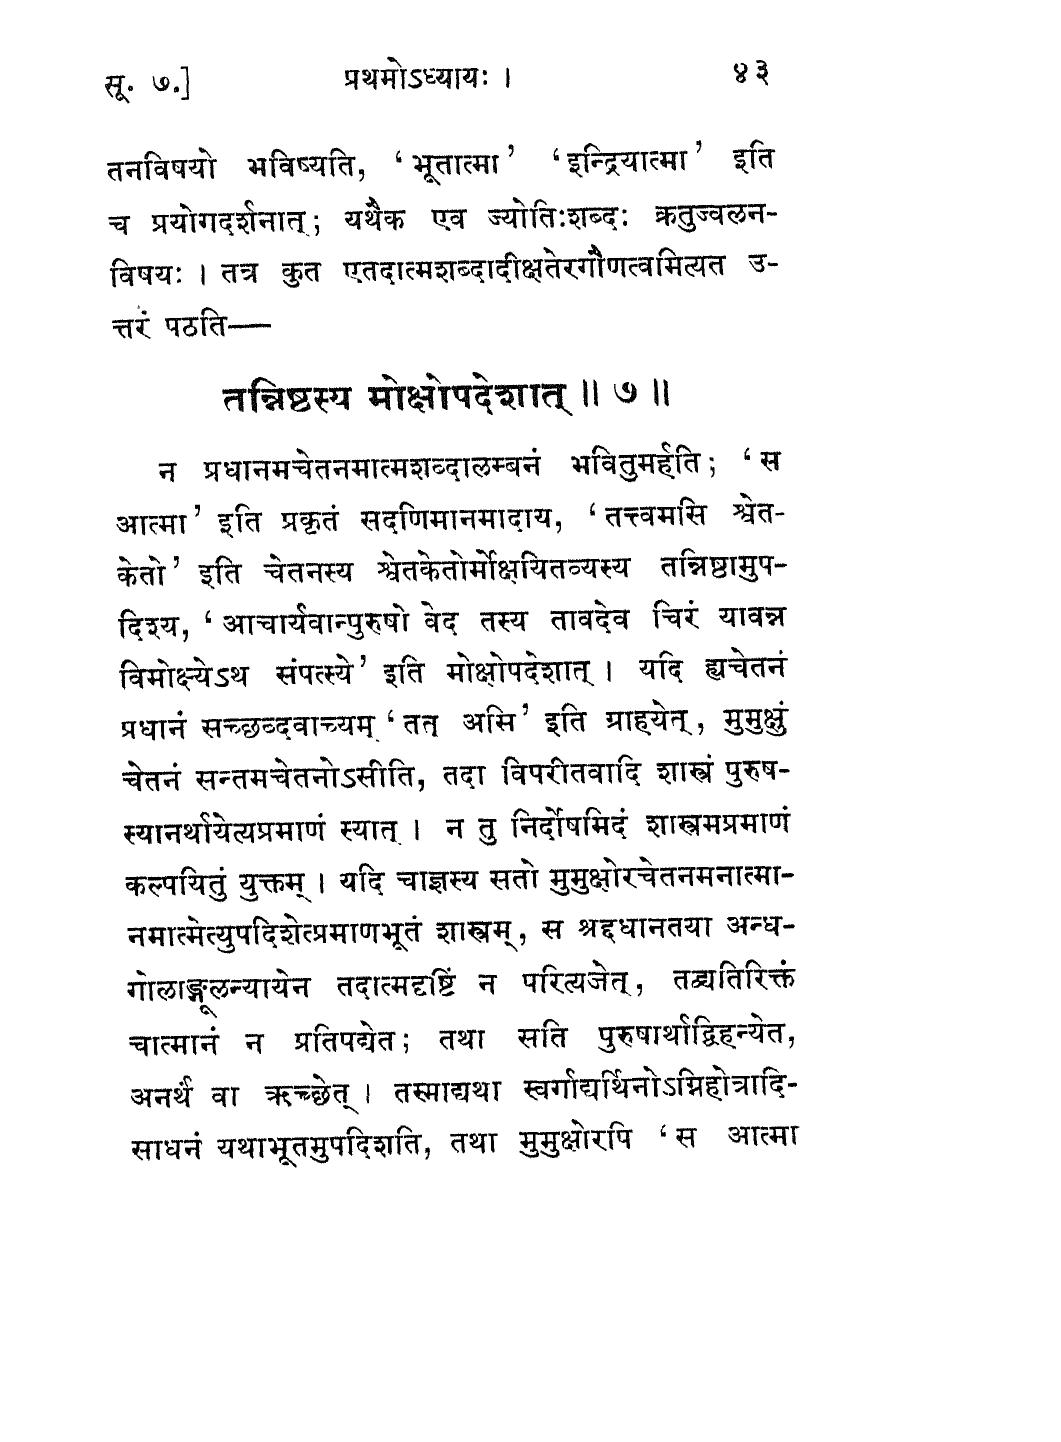

In [ ]:
cv2_imshow(img)


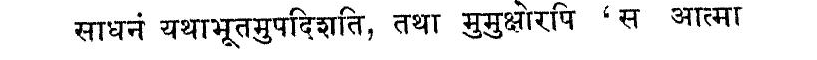

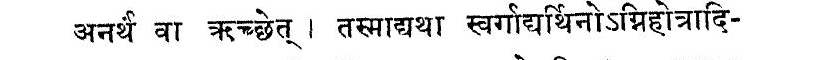

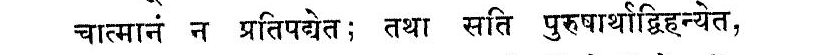

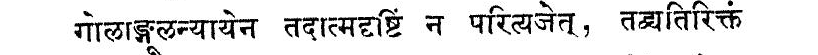

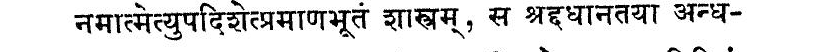

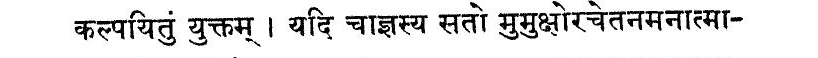

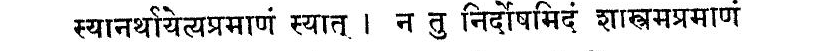

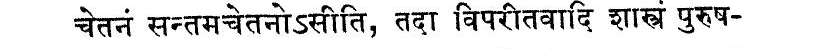

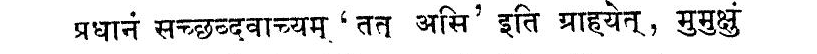

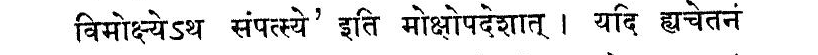

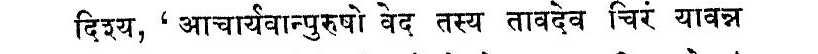

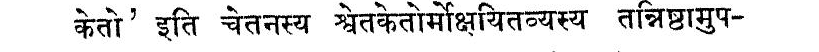

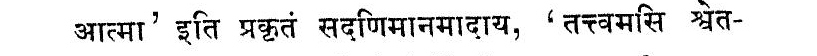

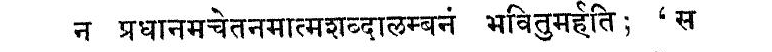

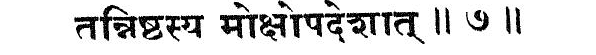

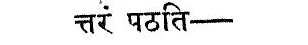

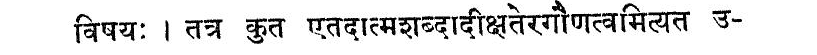

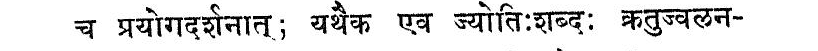

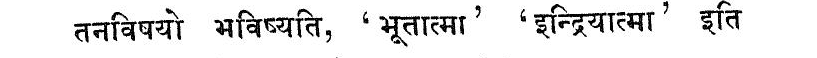

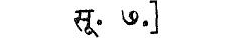

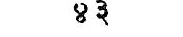

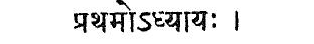

In [ ]:
bboxes = []
bboxes_img = img.copy()
contours = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
contours = contours[0] if len(contours) == 2 else contours[1]
i=0
for cntr in contours:
    x,y,w,h = cv2.boundingRect(cntr)
    h=h+10
    cv2.rectangle(bboxes_img, (x, y), (x+w, y+h), (0,0,255), 1)
    bboxes.append((x,y,w,h))
    box_image = img[y : y+h, x: x+w]
    cv2_imshow(box_image)
    cv2.imwrite("test"+str(i)+".jpg",box_image)
    i=i+1
    print("\n\n ")
#cv2.imwrite("image_name.jpg", box_image)
#cv2_imshow(bboxes_img)

In [ ]:
len(contours)

24

In [ ]:
import cv2
import math
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import os
import warnings
warnings.filterwarnings('ignore')
#%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
sns.set(rc={'figure.figsize' : (22, 10)})
sns.set_style("darkgrid", {'axes.grid' : True})

In [ ]:
def showImg(img, cmap=None):
    plt.imshow(img, cmap=cmap, interpolation = 'bicubic')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()

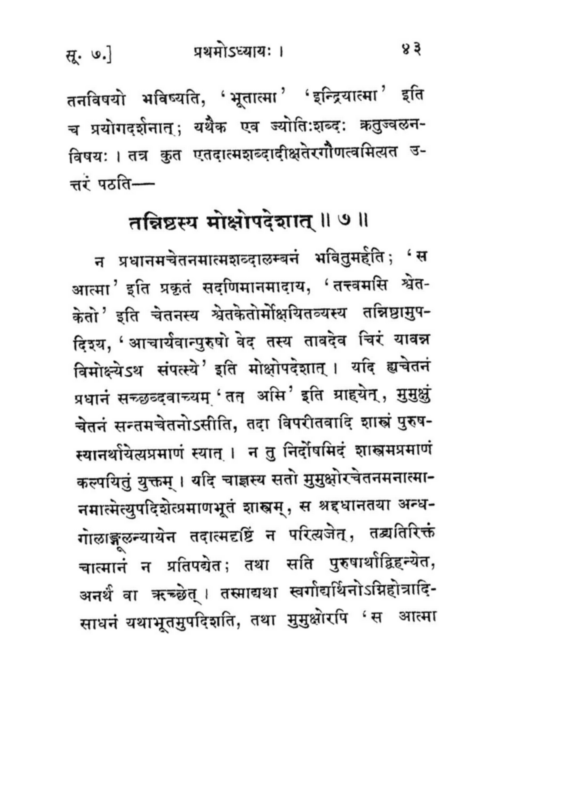

In [ ]:
new = "pe-ocr-sanskrit/OCR-Images-Annotation/BHSv1S1/page-095.jpeg"
img1=cv2.imread(new)
showImg(img1, cmap='gray')

In [ ]:
# Calculate skew angle of an image
def getSkewAngle(cvImage) -> float:
    # Prep image, copy, convert to gray scale, blur, and threshold
    newImage = cvImage.copy()
    gray = cv2.cvtColor(newImage, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (9, 9), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Apply dilate to merge text into meaningful lines/paragraphs.
    # Use larger kernel on X axis to merge characters into single line, cancelling out any spaces.
    # But use smaller kernel on Y axis to separate between different blocks of text
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 5))
    dilate = cv2.dilate(thresh, kernel, iterations=5)

    # Find all contours
    contours, hierarchy = cv2.findContours(dilate, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key = cv2.contourArea, reverse = True)

    # Find largest contour and surround in min area box
    largestContour = contours[0]
    minAreaRect = cv2.minAreaRect(largestContour)

    # Determine the angle. Convert it to the value that was originally used to obtain skewed image
    angle = minAreaRect[-1]
    if angle < -45:
        angle = 90 + angle
    return -1.0 * angle

In [ ]:
# Rotate the image around its center
def rotateImage(cvImage, angle: float):
    newImage = cvImage.copy()
    (h, w) = newImage.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    newImage = cv2.warpAffine(newImage, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return newImage

# Deskew image
def deskew(cvImage):
    angle = getSkewAngle(cvImage)
    return rotateImage(cvImage, -1.0 * angle)

In [ ]:
img=deskew(img1)
cv2.imwrite(new, img)

True

In [ ]:
new

'pe-ocr-sanskrit/OCR-Images-Annotation/BHSv1S1/page-095.jpeg'

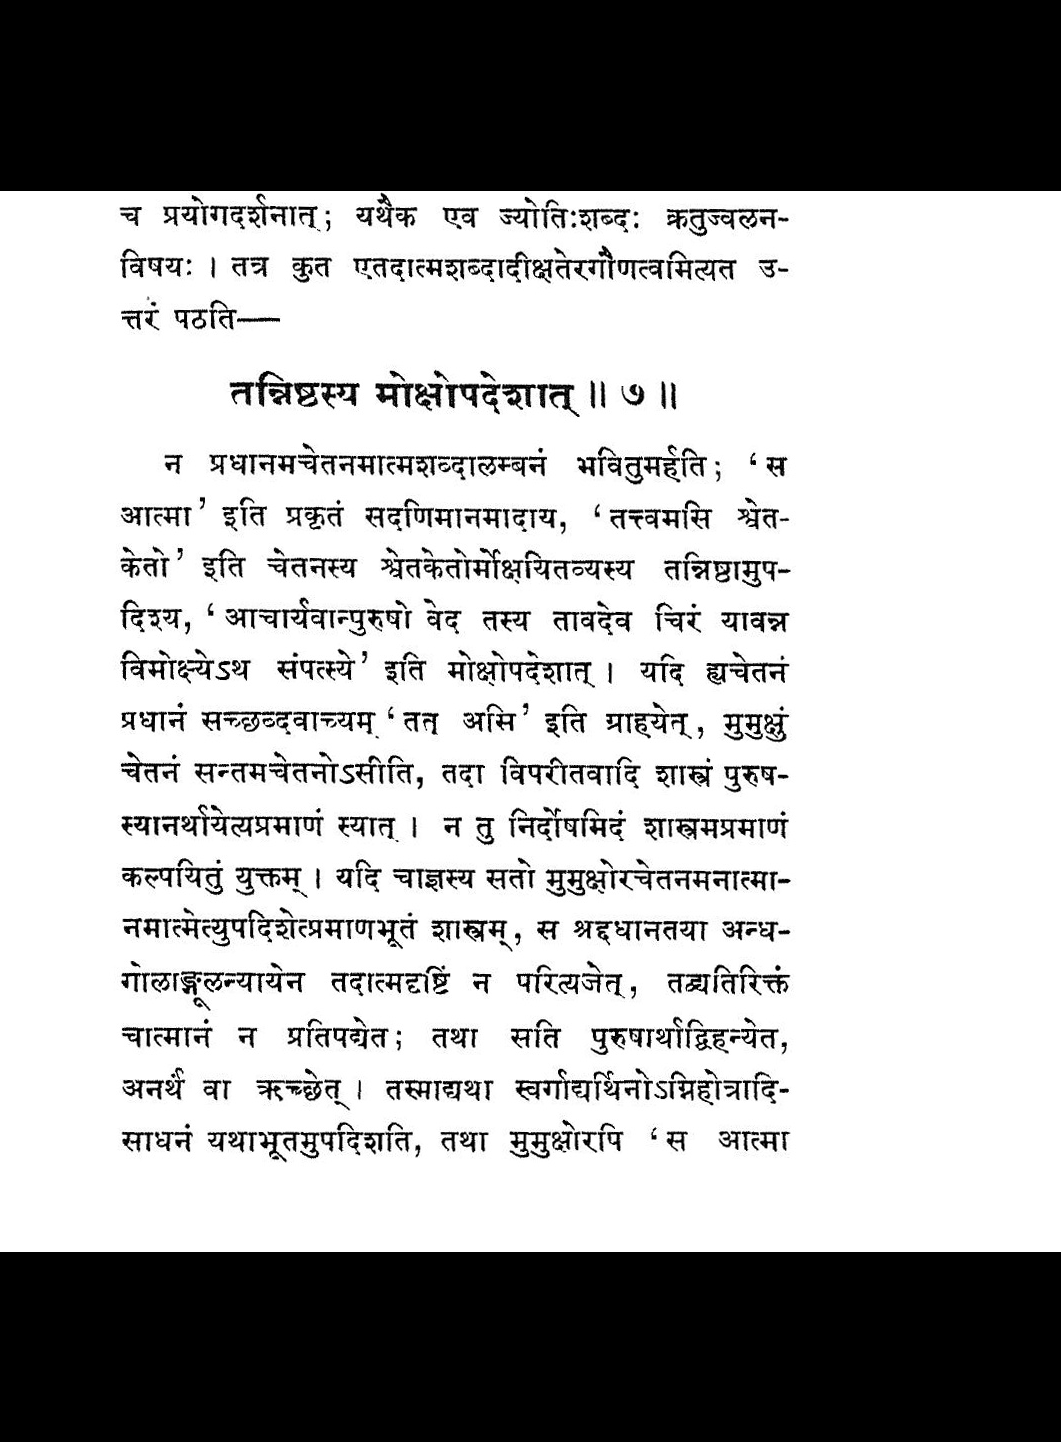

-1

In [ ]:
import imutils
image = cv2.imread(new)

rot = imutils.rotate(image, angle=270)
cv2_imshow(rot)
cv2.imwrite("rot.jpg",rot)
cv2.waitKey(0)

In [ ]:
img1=rot

In [ ]:
print(img1.ndim)
print(img1.shape)

3
(1437, 962, 3)


In [ ]:
img2 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
print(img2.shape)

(1437, 962)


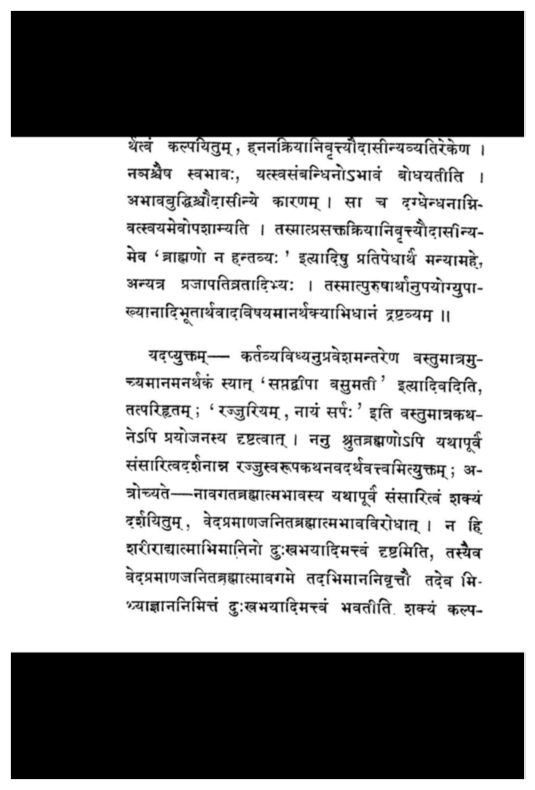

In [ ]:
showImg(img2, cmap='gray')

In [ ]:
type(img2)

numpy.ndarray

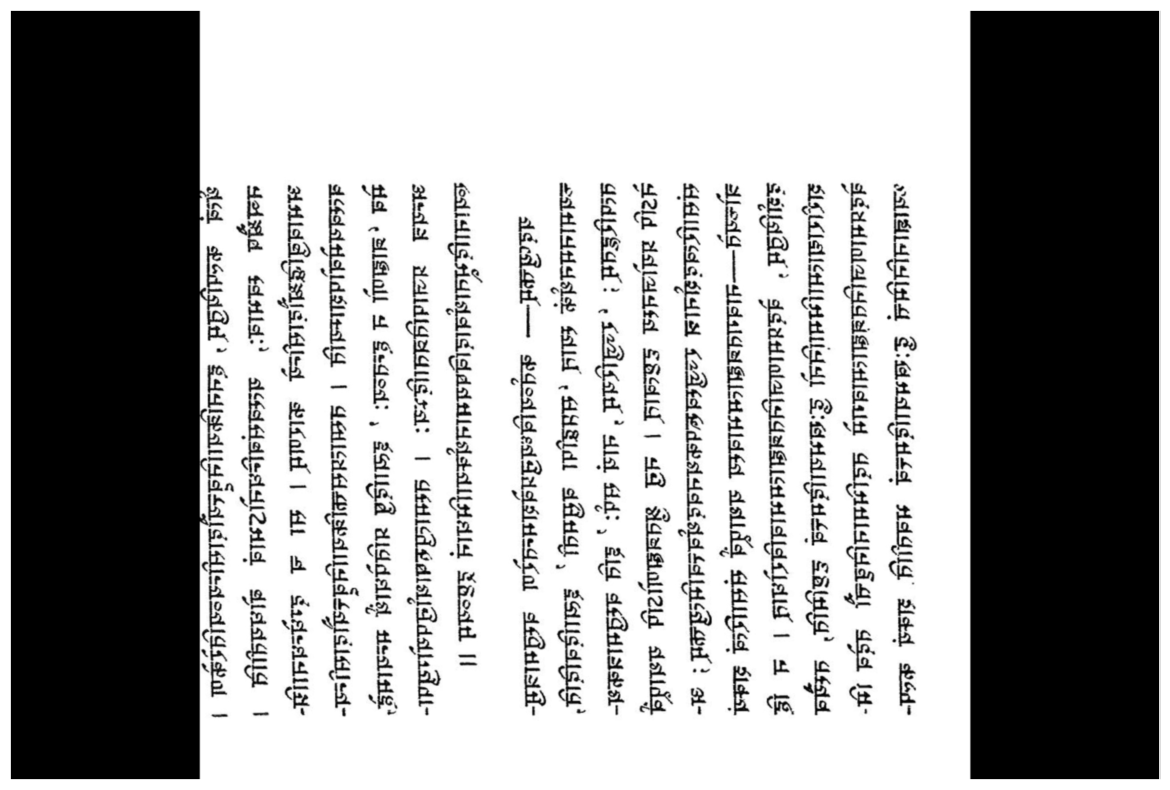

In [ ]:
img3 = np.transpose(img2)
showImg(img3, cmap='gray')

In [ ]:
img = np.arange(16).reshape((4,4))
img

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15]])

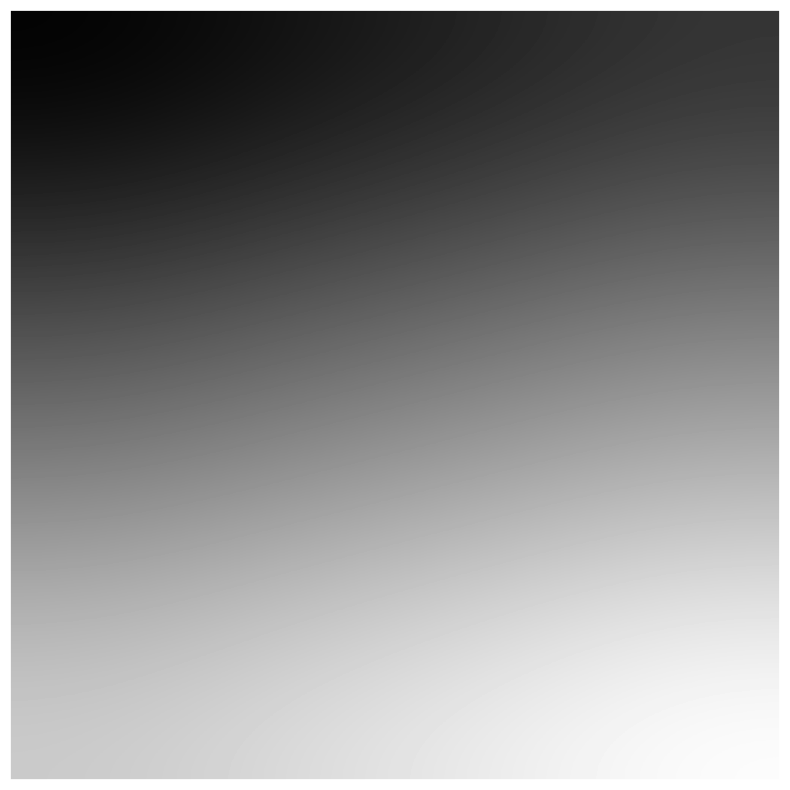

In [ ]:
showImg(img, cmap='gray')

In [ ]:
def createKernel(kernelSize, sigma, theta):
    "create anisotropic filter kernel according to given parameters"
    assert kernelSize % 2 # must be odd size
    halfSize = kernelSize // 2

    kernel = np.zeros([kernelSize, kernelSize])
    sigmaX = sigma
    sigmaY = sigma * theta

    for i in range(kernelSize):
        for j in range(kernelSize):
            x = i - halfSize
            y = j - halfSize

            expTerm = np.exp(-x**2 / (2 * sigmaX) - y**2 / (2 * sigmaY))
            xTerm = (x**2 - sigmaX**2) / (2 * math.pi * sigmaX**5 * sigmaY)
            yTerm = (y**2 - sigmaY**2) / (2 * math.pi * sigmaY**5 * sigmaX)

            kernel[i, j] = (xTerm + yTerm) * expTerm

    kernel = kernel / np.sum(kernel)
    return kernel

In [ ]:
kernelSize=9
sigma=4
theta=1.5
#25, 0.8, 3.5

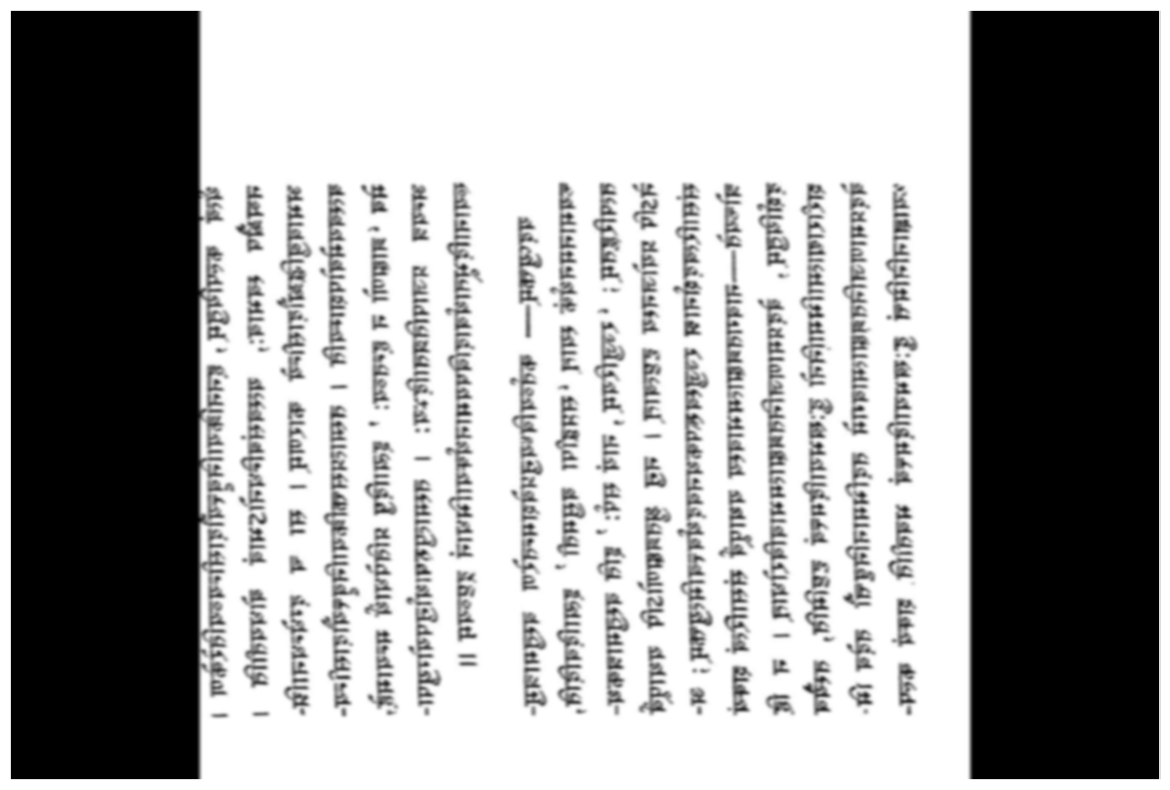

In [ ]:
imgFiltered1 = cv2.filter2D(img3, -1, createKernel(kernelSize, sigma, theta), borderType=cv2.BORDER_REPLICATE)
showImg(imgFiltered1, cmap='gray')

In [ ]:
def applySummFunctin(img):
    res = np.sum(img, axis = 0)    #  summ elements in columns
    return res

In [ ]:
def normalize(img):
    (m, s) = cv2.meanStdDev(img)
    m = m[0][0]
    s = s[0][0]
    img = img - m
    img = img / s if s>0 else img
    return img
img4 = normalize(imgFiltered1)

In [ ]:
(m, s) = cv2.meanStdDev(imgFiltered1)
m[0][0]

154.9215310540989

In [ ]:
summ = applySummFunctin(img4)
print(summ.ndim)
print(summ.shape)

1
(1437,)


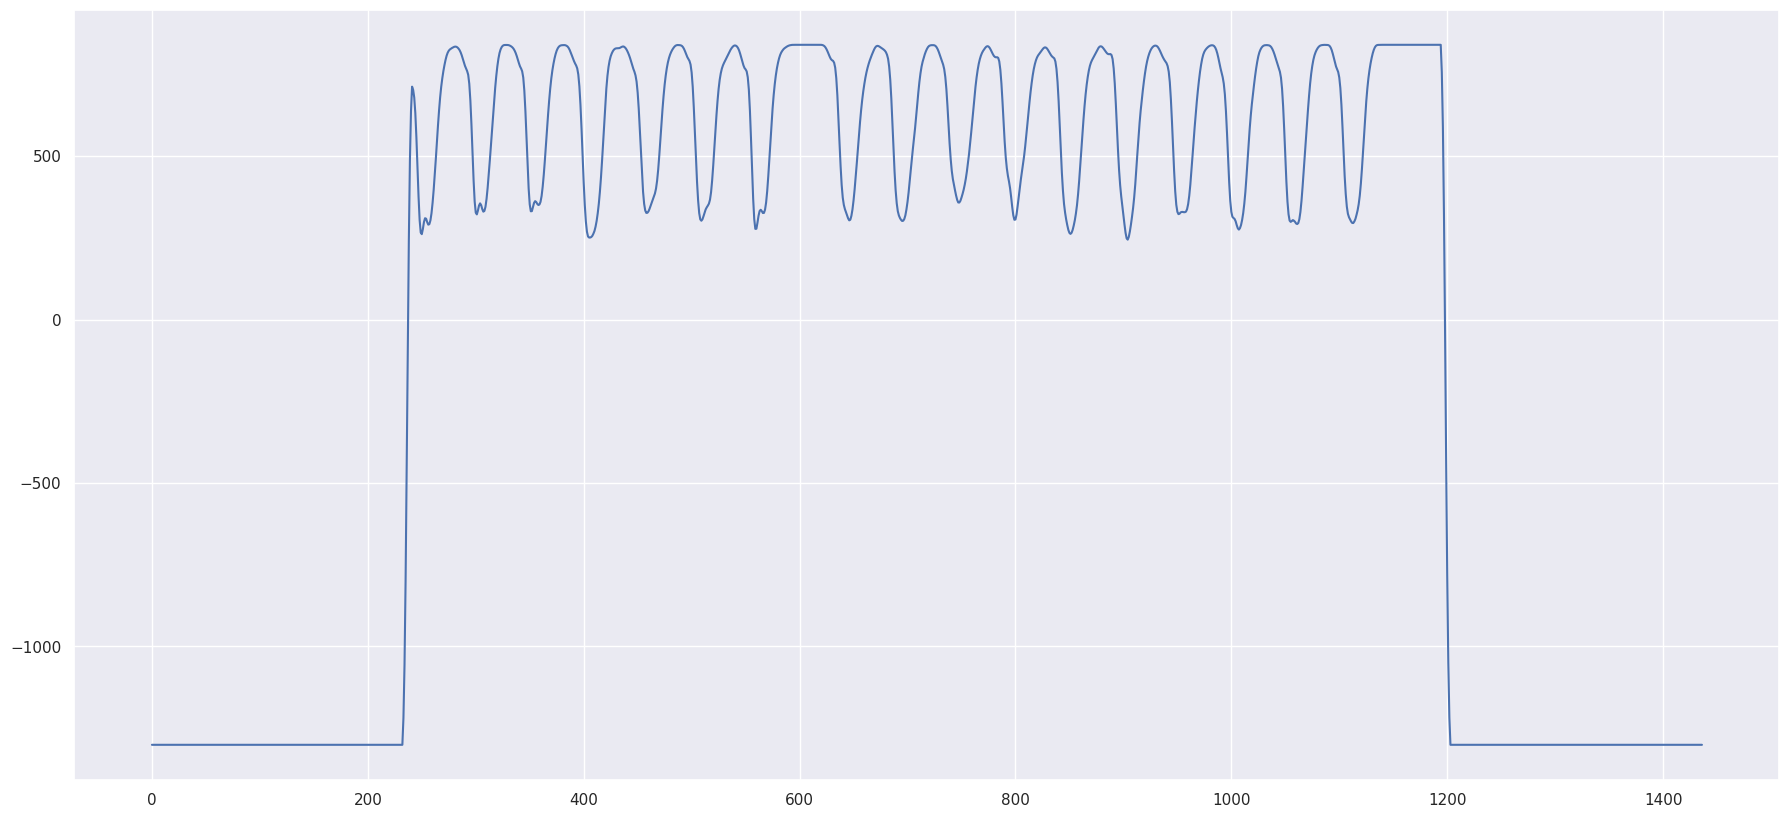

In [ ]:
plt.plot(summ)
plt.show()

In [ ]:
def smooth(x, window_len=11, window='hanning'):
#     if x.ndim != 1:
#         raise ValueError("smooth only accepts 1 dimension arrays.")
    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")
    if window_len<3:
        return x
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")
    s = np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w = np.ones(window_len,'d')
    else:
        w = eval('np.'+window+'(window_len)')

    y = np.convolve(w/w.sum(),s,mode='valid')
    return y

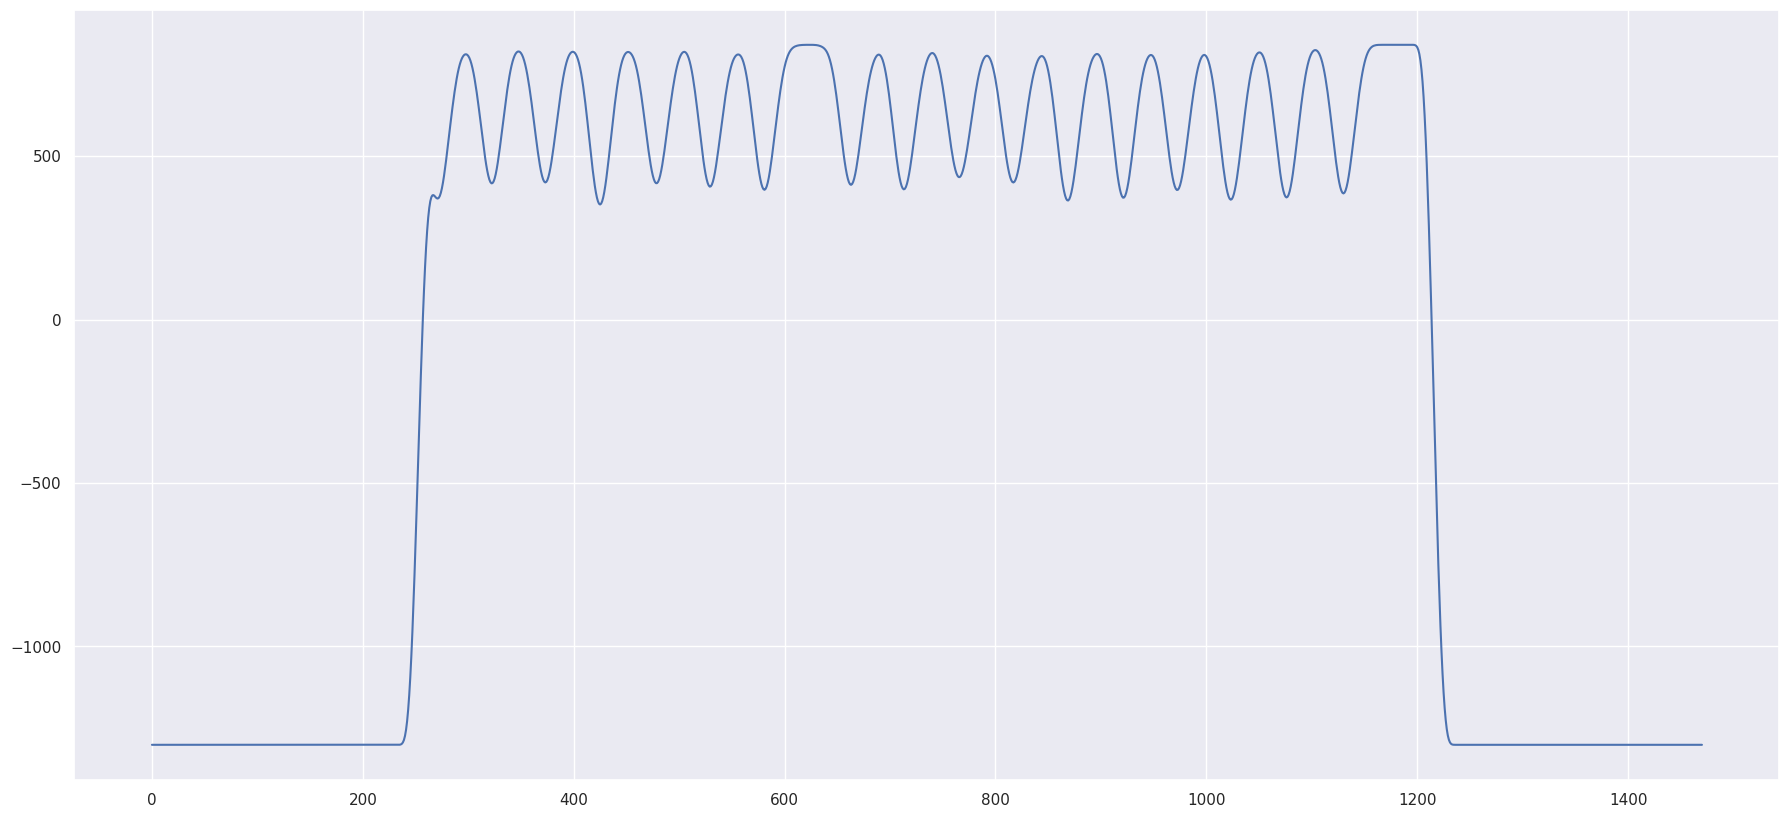

In [ ]:
windows=['flat', 'hanning', 'hamming', 'bartlett', 'blackman']
smoothed = smooth(summ, 35)
plt.plot(smoothed)
plt.show()

In [ ]:
from scipy.signal import argrelmin
mins = argrelmin(smoothed, order=2)
arr_mins = np.array(mins)

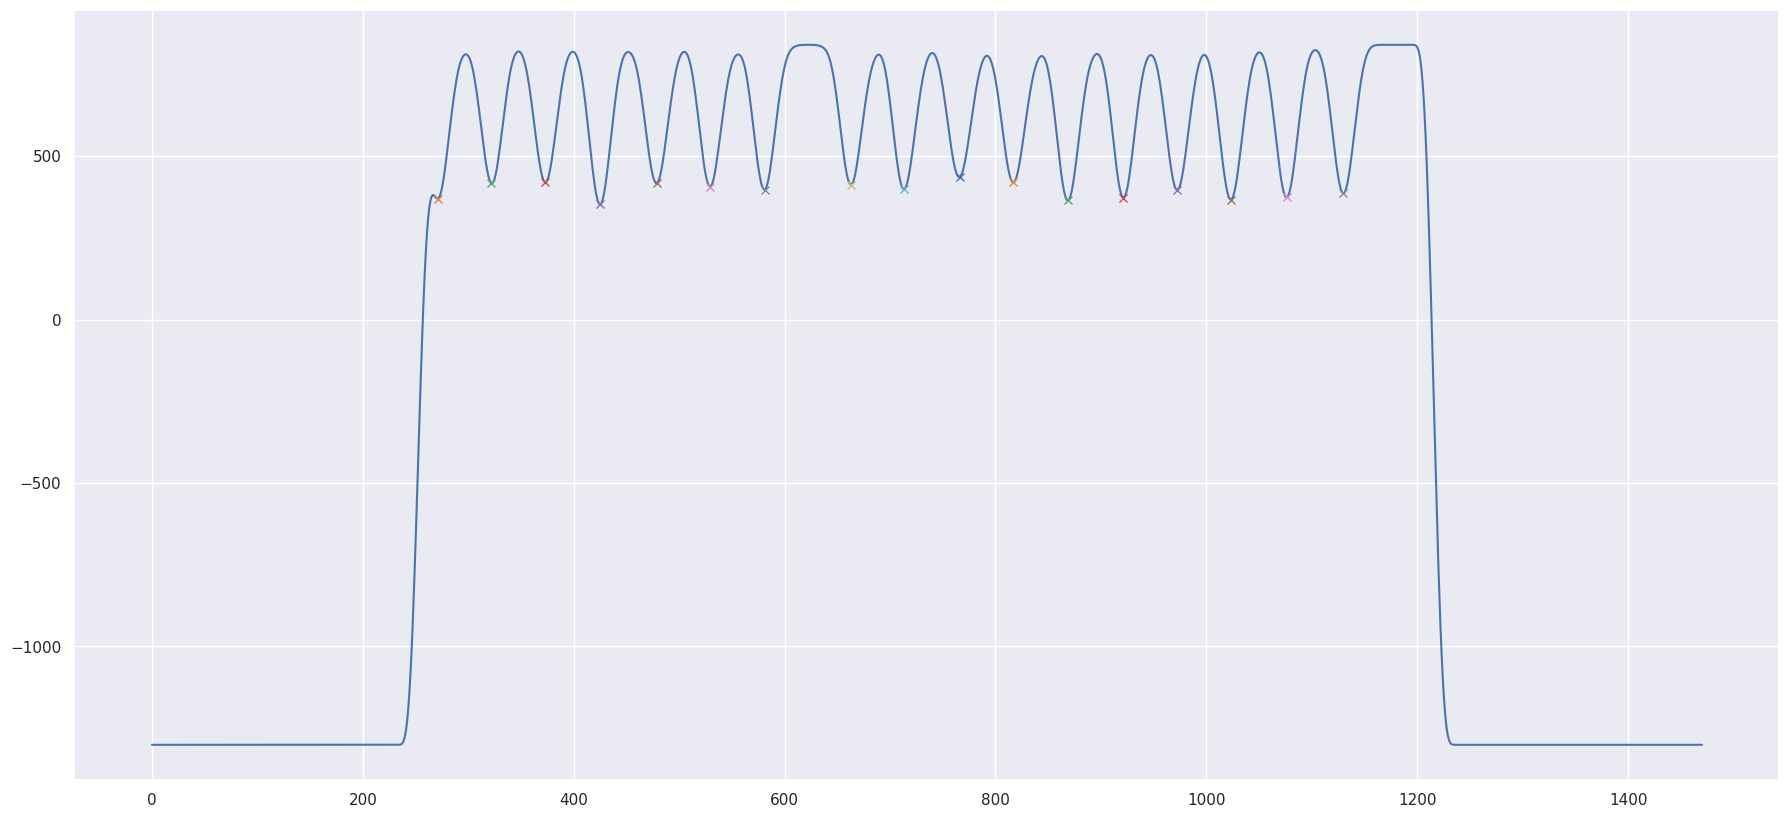

In [ ]:
plt.plot(smoothed)
plt.plot(arr_mins, smoothed[arr_mins], "x")
plt.show()

In [ ]:
img4.shape

(962, 1437)

In [ ]:
type(arr_mins[0][0])

numpy.int64

In [ ]:
def crop_text_to_lines(text, blanks):
    x1 = 0
    y = 0
    lines = []
    for i, blank in enumerate(blanks):
        x2 = blank
        print("x1=", x1, ", x2=", x2, ", Diff= ", x2-x1)
        line = text[:, x1:x2]
        lines.append(line)
        x1 = blank
    return lines

In [ ]:
def display_lines(lines_arr, orient='vertical'):
    plt.figure(figsize=(30, 30))
    if not orient in ['vertical', 'horizontal']:
        raise ValueError("Orientation is on of 'vertical', 'horizontal', defaul = 'vertical'")
    if orient == 'vertical':
        for i, l in enumerate(lines_arr):
            line = l
            plt.subplot(2, 10, i+1)  # A grid of 2 rows x 10 columns
            plt.axis('off')
            plt.title("Line #{0}".format(i))
            _ = plt.imshow(line, cmap='gray', interpolation = 'bicubic')
            plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    else:
            for i, l in enumerate(lines_arr):
                line = l
                plt.subplot(40, 1, i+1)  # A grid of 40 rows x 1 columns
                plt.axis('off')
                plt.title("Line #{0}".format(i))
                _ = plt.imshow(line, cmap='gray', interpolation = 'bicubic')
                plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()

In [ ]:
found_lines = crop_text_to_lines(img3, arr_mins[0])

x1= 0 , x2= 271 , Diff=  271
x1= 271 , x2= 322 , Diff=  51
x1= 322 , x2= 373 , Diff=  51
x1= 373 , x2= 425 , Diff=  52
x1= 425 , x2= 479 , Diff=  54
x1= 479 , x2= 529 , Diff=  50
x1= 529 , x2= 581 , Diff=  52
x1= 581 , x2= 663 , Diff=  82
x1= 663 , x2= 713 , Diff=  50
x1= 713 , x2= 766 , Diff=  53
x1= 766 , x2= 817 , Diff=  51
x1= 817 , x2= 869 , Diff=  52
x1= 869 , x2= 921 , Diff=  52
x1= 921 , x2= 972 , Diff=  51
x1= 972 , x2= 1023 , Diff=  51
x1= 1023 , x2= 1076 , Diff=  53
x1= 1076 , x2= 1130 , Diff=  54


In [ ]:
found_lines[2]

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [ ]:
tf.compat.v1.disable_eager_execution()
sess = tf.compat.v1.Session()
found_lines_arr = []
with sess.as_default():
    for i in range(len(found_lines)-1):
        found_lines_arr.append(tf.expand_dims(found_lines[i], -1).eval())

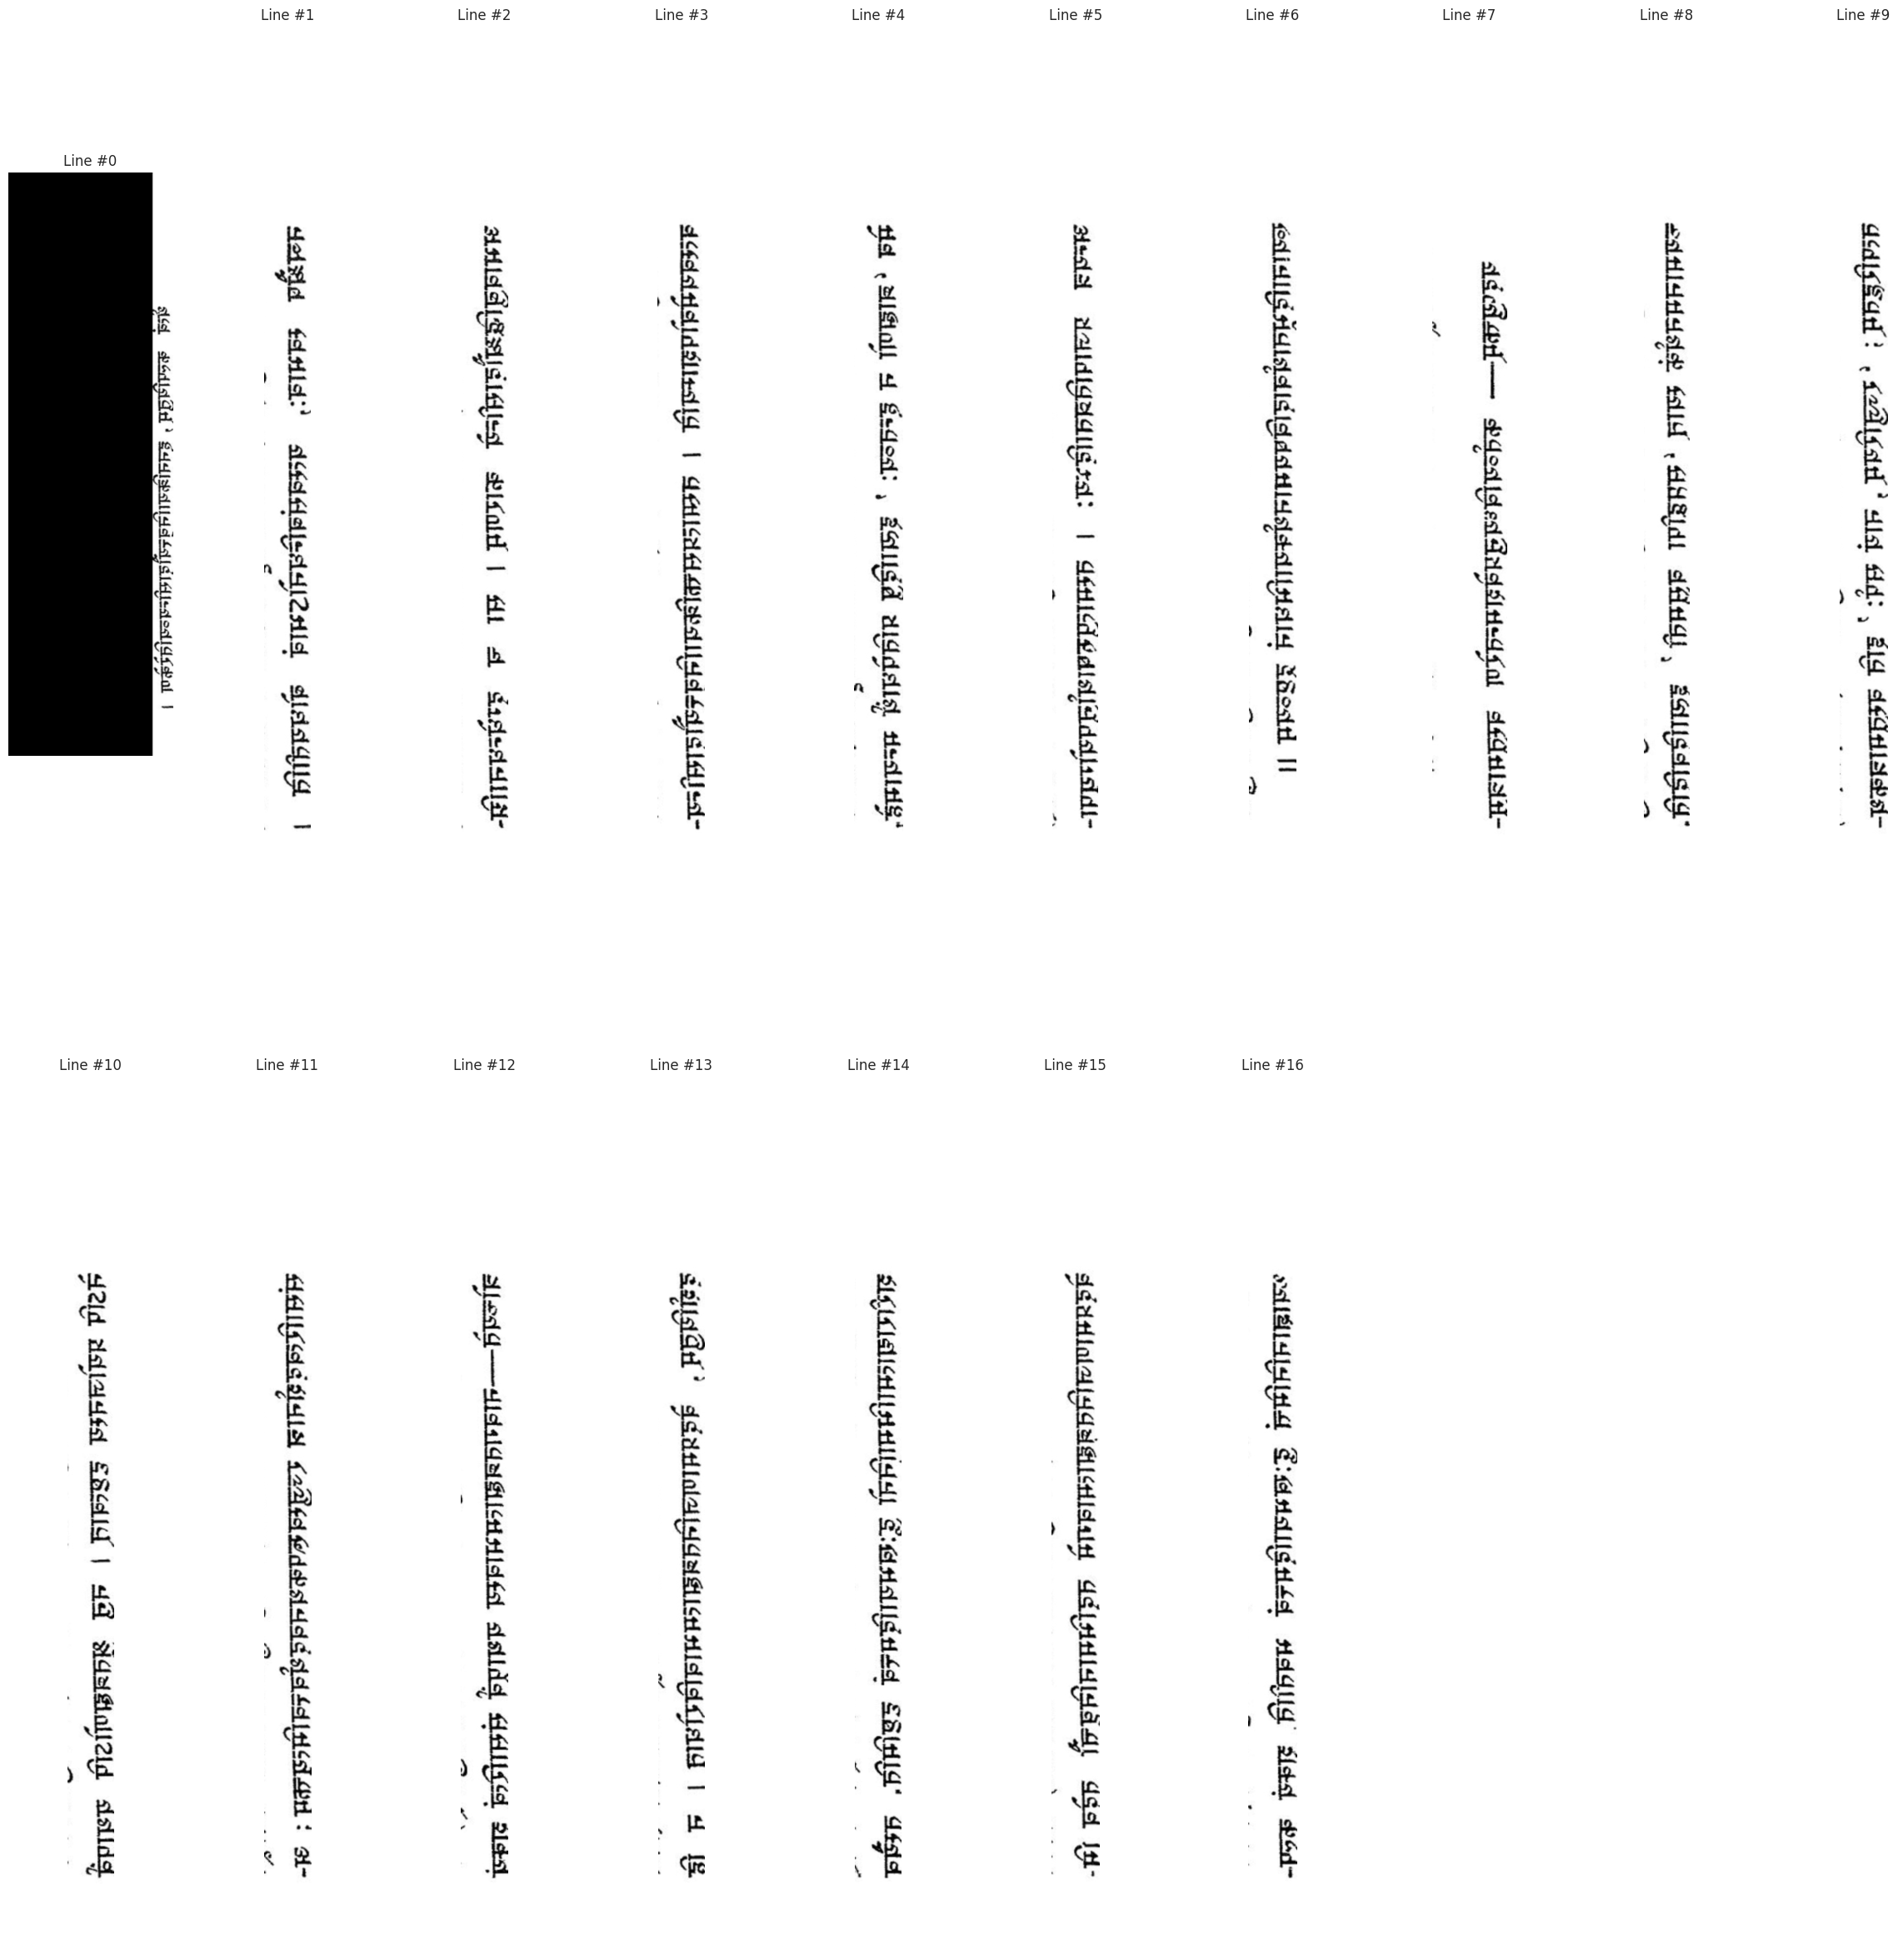

In [ ]:
display_lines(found_lines)

In [ ]:
def transpose_lines(lines):
    res = []
    for l in lines:
        line = np.transpose(l)
        res.append(line)
    return res

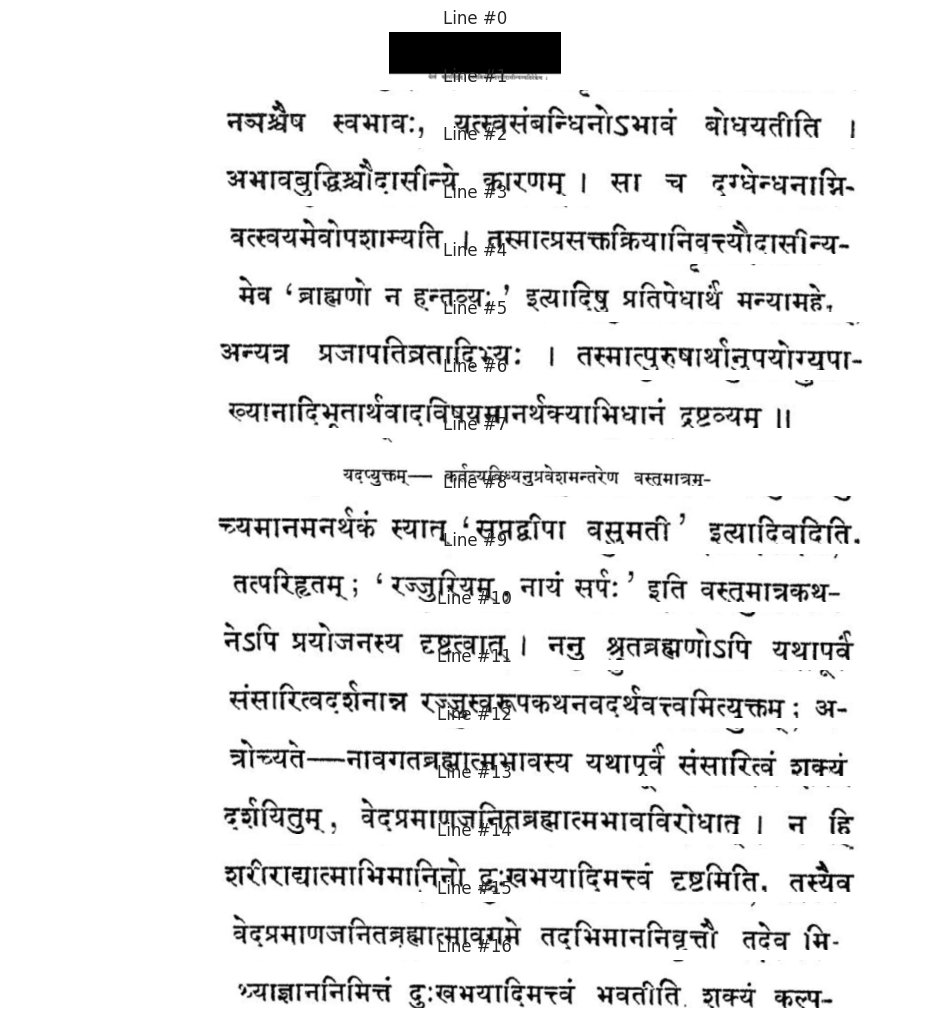

In [ ]:
res_lines = transpose_lines(found_lines)
display_lines(res_lines, 'horizontal')

In [ ]:
img9 = cv2.imread('your_image_path.jpg')
bboxes_img = img9.copy()

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply thresholding to obtain a binary image
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Find contours in the binary image
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Sort contours based on y-coordinate
contours = sorted(contours, key=lambda cnt: cv2.boundingRect(cnt)[1])

# Minimum height threshold for filtering out small bounding boxes
MIN_HEIGHT_THRESHOLD = 10

# List to store the row bounding boxes
row_bboxes = []

# Iterate over the contours
for cntr in contours:
    x, y, w, h = cv2.boundingRect(cntr)

    # Filter out small bounding boxes
    if h >= MIN_HEIGHT_THRESHOLD:
        cv2.rectangle(bboxes_img, (x, y), (x + w, y + h), (0, 0, 255), 1)
        row_bboxes.append((x, y, w, h))

# Display the image with row bounding boxes
cv2_imshow(bboxes_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

AttributeError: ignored